In [1]:
from solo_epd_loader import epd_load, calc_electrons, combine_pixels
from run_the_fit_protons import *
from epd_plot_shift_electrons_protons import * # !!!!!!!

/home/annafed/anaconda3/envs/annamaria/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
species = 'protons'  # !!!!!!!!! DO NOT CHANGE. THIS NOTEBOOK IS ONLY MEANT TO BE USED FOR PROTONS.


# Notebook to plot and fit SolO EPD SEP data
#### General information about the notebook:
This Notebook allows the user to load, plot and fit SolO EPD SEP energy data.
The data loading process uses solo-epd-loader. 
<br>This package can be installed simply by running   %pip install git+https://github.com/jgieseler/solo-epd-loader    in any cell of the notebook. Note that this should only be done once. The package can be updated by running the following: %pip install git+https://github.com/jgieseler/solo-epd-loader --upgrade
<br>The data will be saved as cdf files to a local folder provided by the user. The data is then used to create dataframes of the electron or proton data for each instrument and energy channel. 
<br>The flux data will be plotted as a timeseries. The timeseries include all the energy channels for each instrument. Together with the timeseries we plot the pitch angle coverage. (add  expl pa) We find the flux peak for each energy channel using the provided injection time and following the velocity dispersion. These values will then be plotted against the energy corresponding to the channels to form a spectrum. 
<br>The spectrum can then be fit with various functions to analyse its shape.


### NECESSARY INPUTS
Choose a folder where you wish to save the data from the loading, plotting and fitting process. 
If create_sub_folders = True, a new folder will be created for each event and the data etc will be saved there. 
<br> date : (datetime) format: datetime(yyyy, mm, dd, HH, MM) The date and approximate injection time of the event.

In [3]:
path =   r'/home/annafed/Documents/proton_analysis/'
create_sub_folders = True
threshold_folders = False # if true saving to separate folders does not work. 
plot_n_data_folders = True #saves plots in separate folders
save_fit_run_variables_to_separate_folders = True # saves the file with the results from the fit and the one with all imput variables to separate folders

date = datetime(2022, 8, 30, 13, 2)

date_string = str(date.date())

saving = True

pixels = False

Choose a viewing direction and time averaging for the data.
<br> __direction__ (string): 'sun', 'asun', 'north', 'south'    NOTE: STEP has 'sun' direction only. 
<br> __avraging__(string):  data averaging pd strings e.g. '1s', '1min', '1h' etc

<br> Possible values:
<br>‘W’
<br>‘D’ / ‘days’ / ‘day’
<br>‘hours’ / ‘hour’ / ‘hr’ / ‘h’
<br>‘m’ / ‘minute’ / ‘min’ / ‘minutes’ / ‘T’
<br>‘S’ / ‘seconds’ / ‘sec’ / ‘second’
<br>‘ms’ / ‘milliseconds’ / ‘millisecond’ / ‘milli’ / ‘millis’ / ‘L’
<br>‘us’ / ‘microseconds’ / ‘microsecond’ / ‘micro’ / ‘micros’ / ‘U’
<br>‘ns’ / ‘nanoseconds’ / ‘nano’ / ‘nanos’ / ‘nanosecond’ / ‘N’

<br> __bg_subtraction__ (bool): if True will use background subtracted data (else choose False)
<br> __step__ (bool): if True step data will be dowloaded and plotted
<br> __ept__ (bool): if True ept data will be dowloaded and plotted
<br> __het__ (bool): if True het data will be dowloaded and plotted



In [4]:
direction = 'sun'
averaging = '1min'

bg_subtraction = True

step = True
ept = True
het = True

__position__: this variable contains information about the location of SolO on the day of the event as well as the travel time of light and protons with energy corresponding to the lowest STEP energy channel (4 keV) and the highest HET energy channel (100 MeV).

In [5]:
position = position_and_traveltime(date, species)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
-------------------------------------------  -----  -----------
Distance of SolO from the Sun                [AU]      0.76
Length of the Parker Spiral for 400 km/s sw  [AU]      0.831181
Travel time of 4 keV protons                 [min]  2365.54
Travel time of 100 MeV protons               [min]    47.6885
Travel time of light                         [min]     6.32073
-------------------------------------------  -----  -----------


In [6]:
position[3][2]

47.6884830569923

### NON-NECESSARY INPUTS

#### LOADING DATA, PLOTTING TIMESERIES AND SPECTRUM (NO FIT)
The following inputs can be changed, but the notebook will run without any furher changes.
<br> __start_date__ and __end_date__ (int or datetime): The start and end date to download data. These should be different only in case the event occurs close to midnight. Automatically done if the event is less than X-hours from midnight. Format: datetime(yyyy, mm, dd) or yyyymmdd.
<br> __plot_start__ and __plot_end__ (string): The start and end time for the timeseries plot. Automatically taken as $\pm$X-hours. Format: 'yyyy-mm-dd-HHMM'
<br> __t_inj__ (string): taken automatically from the previously defined value (date). In the following cell it is only used to create a path for the new folders to save the data. This value is changed later (before the plots e.g. by using the light travel time (position)) to fit the peak into the search window. This value is fixed to the highest HET channel (close traveltime to light tt for electrons), the rest of the window times are calculated using velocity dispersion.
<br> __autodownload__ (bool, defaults to True): If True will automatically download the data to analyse the event.
<br> __data_type__ (string, defaults to 'l2'): 'll' = low latency, 'l1' = level 1 data, 'l2' = level 2 data for scientific research.
<br> __plot_pa__ (bool, defauts to True): plots the pitch angle coverage for the event. 

In [7]:
startdate = date-timedelta(hours = 6)
start_date = startdate.date()
enddate = date+timedelta(hours =  6)
end_date = enddate.date()

plot_start = str(date-timedelta(hours = 5))[:-3].replace(' ', '-').replace(':', '')
plot_end = str(date+timedelta(hours = 3))[:-3].replace(' ', '-').replace(':', '')

t_inj = str(date)[:-3].replace(' ', '-').replace(':', '')
date_folder = t_inj
    
if create_sub_folders:
    create_new_path(path, t_inj, threshold_folders = threshold_folders, contamination_threshold = None, plots_n_data = plot_n_data_folders)
    path_to_folder = path+t_inj+'/'
    plot_path = path_to_folder
if plot_n_data_folders:
    plot_path = path_to_folder+'plots/'

autodownload_data = True
data_type = 'l2'
plot_pa = True

if saving:
    save_fig = True
    save_fit_variables = True
    save_fitrun = True

only_averages = True


Creating new directory /home/annafed/Documents/proton_analysis/2022-08-30-1302
Creating new directory  /home/annafed/Documents/proton_analysis/2022-08-30-1302/plots
Creating new directory  /home/annafed/Documents/proton_analysis/2022-08-30-1302/data


## LOAD DATA

In [8]:
if plot_pa:
    msdate = dt.datetime.combine(pd.to_datetime(plot_start).date(), dt.time.min)
    medate = dt.datetime.combine(pd.to_datetime(plot_end).date()+ dt.timedelta(days=1), dt.time.min) #+ dt.timedelta(days=1)

    mag_srf = solo_mag_loader(msdate, medate, level='l2', frame='srf', av=None, path=path)
    

Loading MAG...


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:   0%|          | 0.00/12.4M [00:00<?, ?B/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:   0%|          | 1.02k/12.4M [00:00<2:44:52, 1.25kB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:   0%|          | 24.4k/12.4M [00:01<06:39, 30.9kB/s]  
solo_l2_mag-srf-normal_20220830_v01.cdf:   1%|          | 120k/12.4M [00:01<01:15, 162kB/s]  
solo_l2_mag-srf-normal_20220830_v01.cdf:   2%|▏         | 264k/12.4M [00:01<00:34, 348kB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:   4%|▍         | 496k/12.4M [00:01<00:18, 644kB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:   8%|▊         | 1.05M/12.4M [00:01<00:07, 1.57MB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:  16%|█▋        | 2.04M/12.4M [00:01<00:03, 3.28MB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:  20%|██        | 2.50M/12.4M [00:01<00:02, 3.36MB/s]
solo_l2_mag-srf-normal_20220830_v01.cdf:  32%|███▏      | 4.02M/12.4M [00:01<00:01, 5.78MB/s]
solo_l2_mag

In [9]:
if step:   
    # read in STEP original data to df_particles_step_org. electron fluxes calculated later with calc_electrons
    df_particles_step_org, energies_step = epd_load(sensor='step', level='l2', startdate=start_date, 
                                                    enddate=end_date, path=path_to_folder, autodownload=True, 
                                                    only_averages=only_averages)
    

Creating dir /home/annafed/Documents/proton_analysis/2022-08-30-1302/l2/epd/step/


solo_L2_epd-step-main_20220830_V01.cdf: 121MB [02:28, 818kB/s]                               


Loading /home/annafed/Documents/proton_analysis/2022-08-30-1302/l2/epd/step/solo_L2_epd-step-main_20220830_V01.cdf


In [10]:
if ept:
    df_protons_ept, df_electrons_ept, energies_ept = epd_load(sensor = 'ept', viewing = direction, level = 'l2',
                                                                  startdate = start_date, enddate = end_date, 
                                                                  path=path, autodownload=True)
    

Creating dir /home/annafed/Documents/proton_analysis/l2/epd/ept/


solo_L2_epd-ept-asun-rates_20220830_V02.cdf: 8.48MB [00:08, 958kB/s]                             
solo_L2_epd-ept-north-rates_20220830_V02.cdf: 8.47MB [00:10, 831kB/s]                             
solo_L2_epd-ept-south-rates_20220830_V02.cdf: 9.77MB [00:09, 988kB/s]                             
solo_L2_epd-ept-sun-rates_20220830_V02.cdf: 10.9MB [00:13, 825kB/s]                             


In [11]:
if het:  
    df_protons_het, df_electrons_het, energies_het = epd_load(sensor = 'het', viewing = direction, level = 'l2',
                                                            startdate = start_date, enddate = end_date, 
                                                            path=path, autodownload=True)
   

Creating dir /home/annafed/Documents/proton_analysis/l2/epd/het/


solo_L2_epd-het-asun-rates_20220830_V01.cdf: 958kB [00:02, 430kB/s]                             
solo_L2_epd-het-north-rates_20220830_V01.cdf: 991kB [00:02, 344kB/s]                             
solo_L2_epd-het-south-rates_20220830_V01.cdf: 1.01MB [00:03, 330kB/s]                             
solo_L2_epd-het-sun-rates_20220830_V01.cdf: 1.04MB [00:03, 309kB/s]                             


## PLOT TIMESERIES AND SPECTRA

<br> __sigma__ (int, defaults to 3.): standard deviation from the background.
<br> __rel_err__ (float, defaults to 0.5): The absolute value of the uncertainty of the bg subtracted flux peak divided by the bg subtracted peak. For protons the value is much higher so consider using e.g. > 0.85 or even 1.
<br> __frac_nan_threshold__ (float, defaults to 0.9): exclude all spectrum values with fraction of non-nan data points in search window lower than the corresponding value.

<br> __t_inj__ (string): taken automatically from previously defined value (date). This value can be changed by using for example the light travel time (position) to fit the peak into the search window. This value is fixed to the highest HET channel (close traveltime to light tt for electrons), the rest of the window times are calculated using velocity dispersion.t_inj = str(date-timedelta(minutes = position[3][2]))[:-3].replace(' ', '-').replace(':', '')

<br> For the __background__ there are two options: either a fixed bg window that starts and ends at the same time for each energy channel or a bg window that follows the peak search window (beacuse of velocity dispersion at different times for different energy channels). 
<br>__For a fixed bg window__: 
<br>__bg_start__ and __bg_end__ (string, defaults to None) 'yyyy-mm-dd-HHMM'
<br>__For a bg window that follows the peak search window__: 
<br>__bg_distance from window__ (str, defauts to '2h'): the distance of the start time of the bg window from the start of the search window. e.g. '60s', '5min', '4h' __bg_period__ (str, defaults to '1h') the length of the bg window. e.g. '60s', '5min', '4h'
<br> __travel_distance__ (float): Length of the Parker Spiral in AU. This is taken automatically from the position variable.
<br> __travel_distance_second_slope__ (float, defaults to None): __travel_distance_second_slope__ > __travel_distance__ If specified this will create a peak search window that broadens at lower energies. If specified set fixed_window = None.
<br> __fixed_window__ (str, defauts to '60min'): the length of the search window. e.g. '60s', '5min', '4h'

In [12]:
sigma = 0
rel_err = 1
frac_nan_threshold = 0.1

In [13]:
# change depending on onset time difference t_inj = str(date-timedelta(minutes = position[3][2]))[:-3].replace(' ', '-').replace(':', '')
t_inj = str(date-timedelta(minutes = 0))[:-3].replace(' ', '-').replace(':', '')

bg_start = None 
bg_end = None 
bg_distance_from_window = '30min'
bg_period = '3h'

travel_distance = 0 #position[0][2]
travel_distance_second_slope = None
fixed_window = '10min' #either input time period in minutes or None


## STEP

Calculating PA coverage for step...
Opening of STEP just a placeholder! Replace with real value! This affects the 'min' and 'max' values of the pitch-angle, not the 'center' ones.


100%|██████████| 2880/2880 [00:00<00:00, 2959.21it/s]
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1315: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_proton_uncertainties['Ion_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


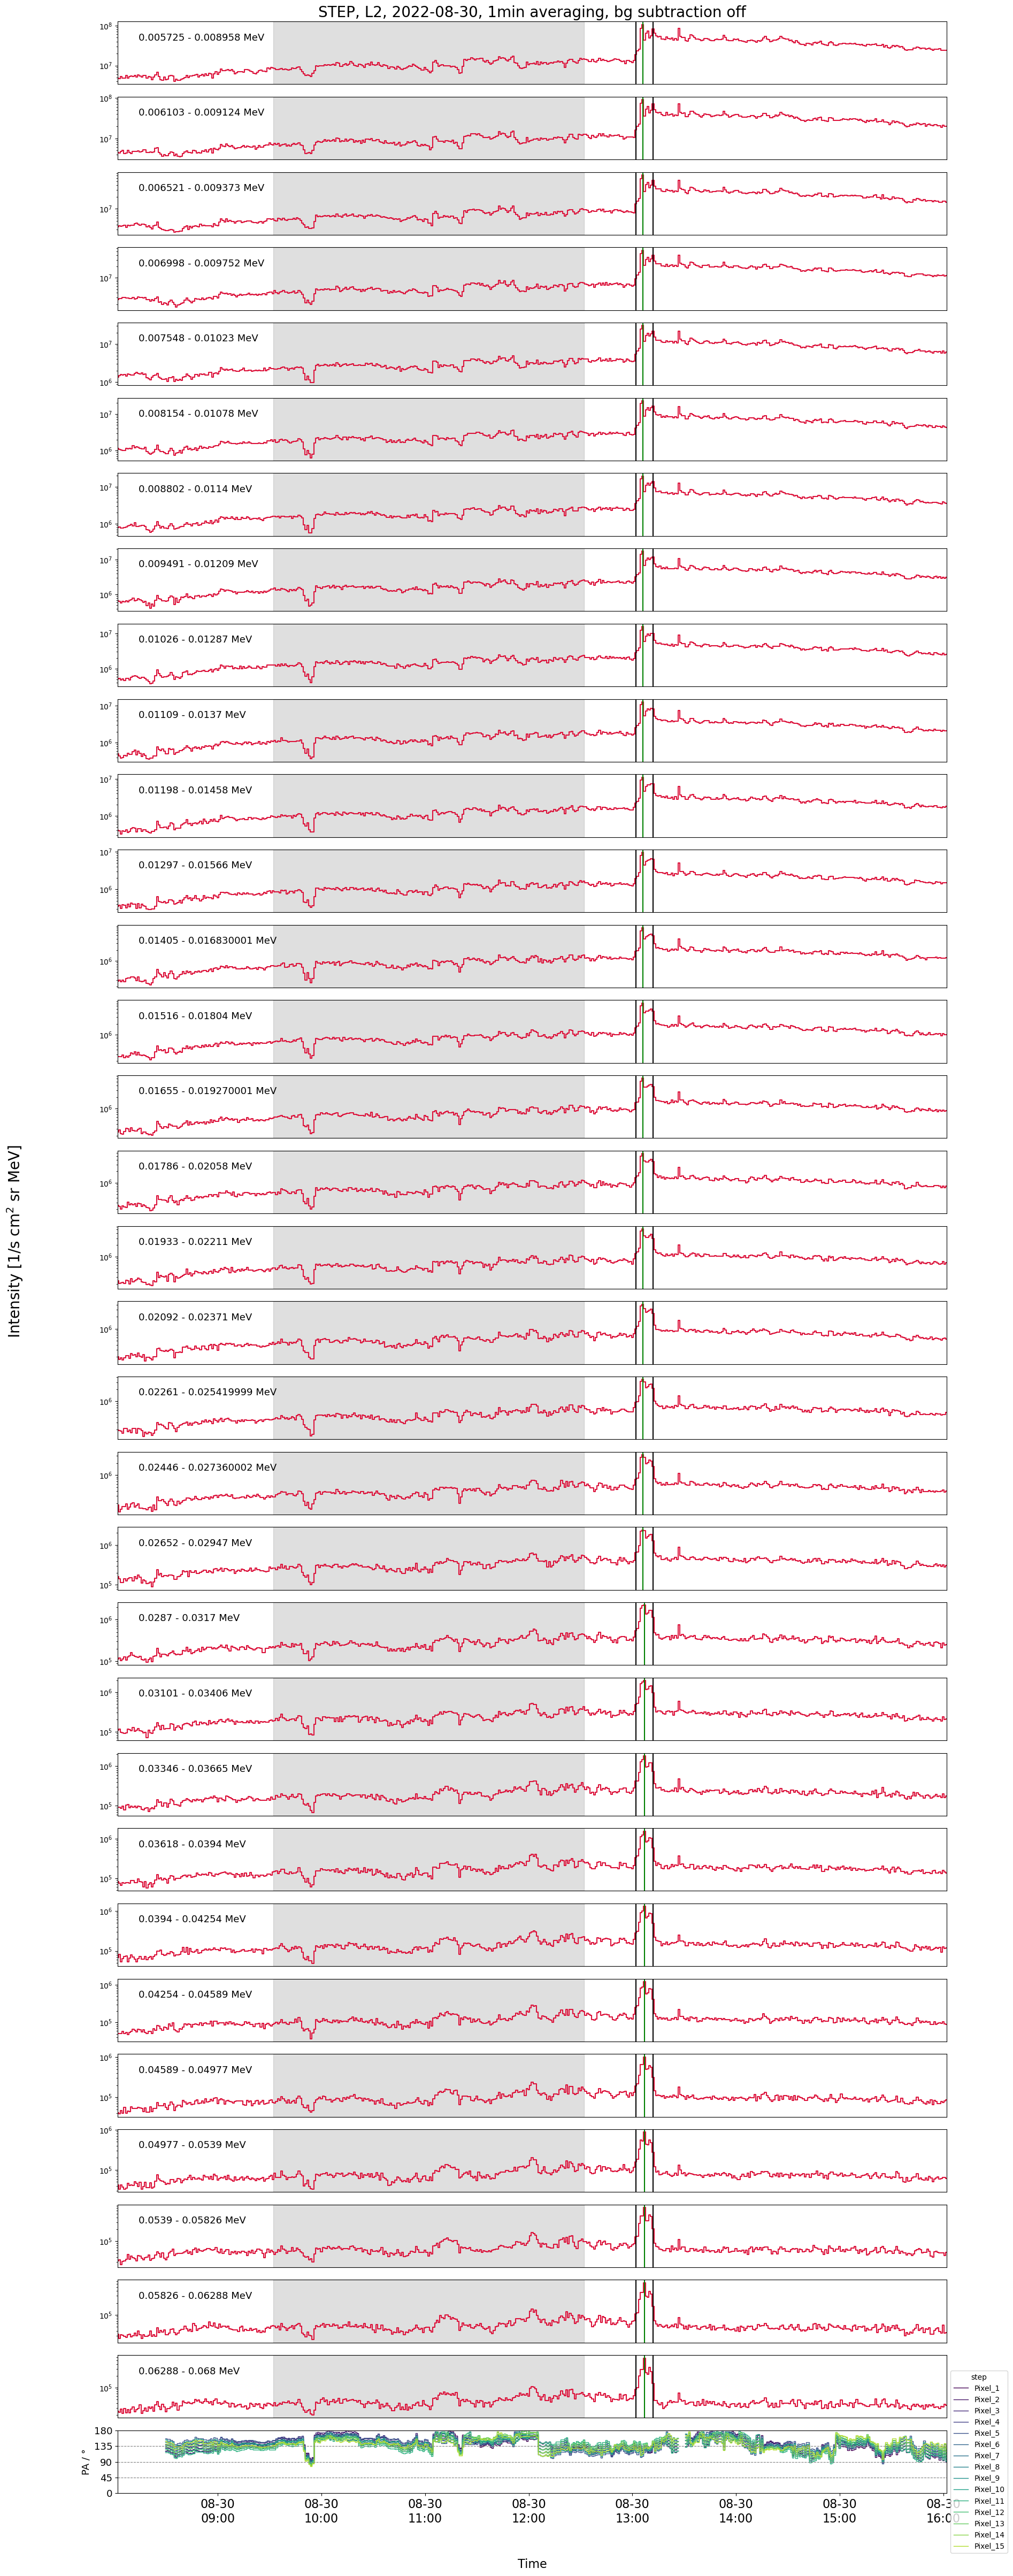

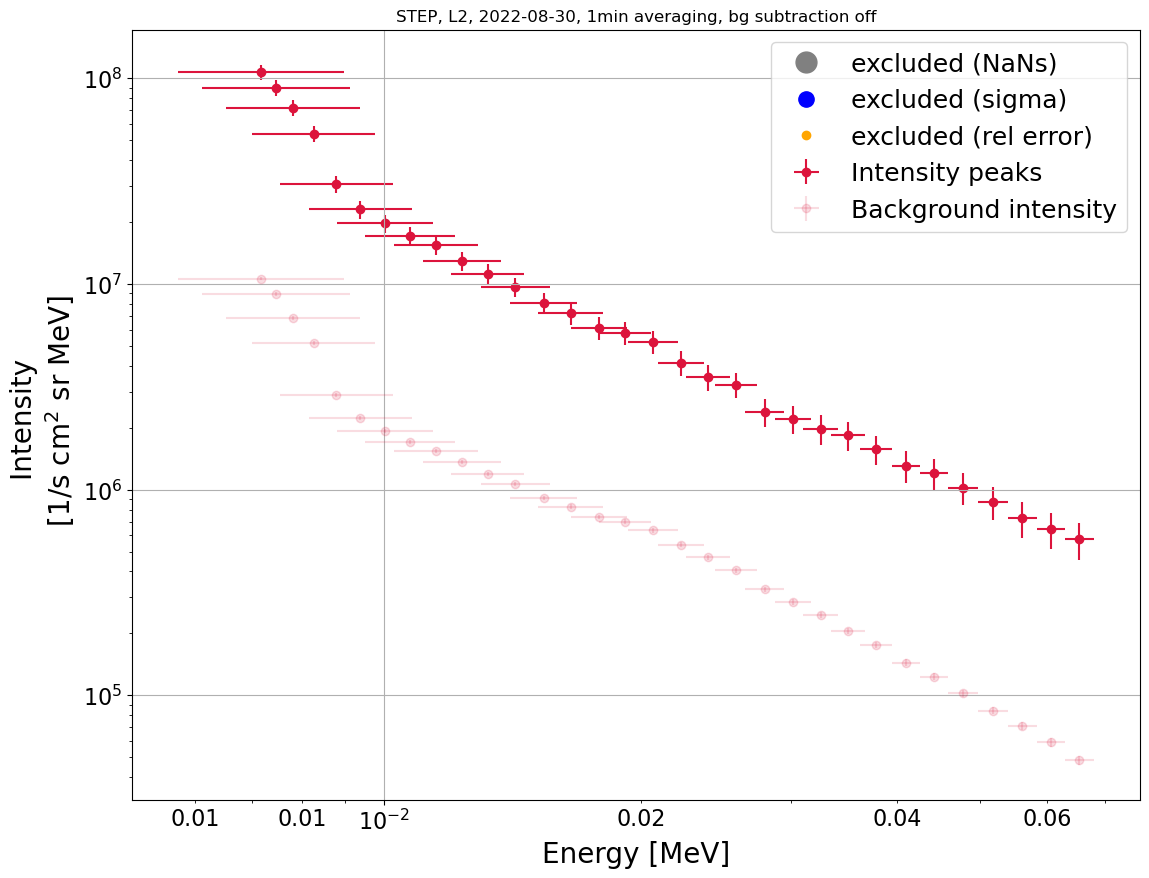

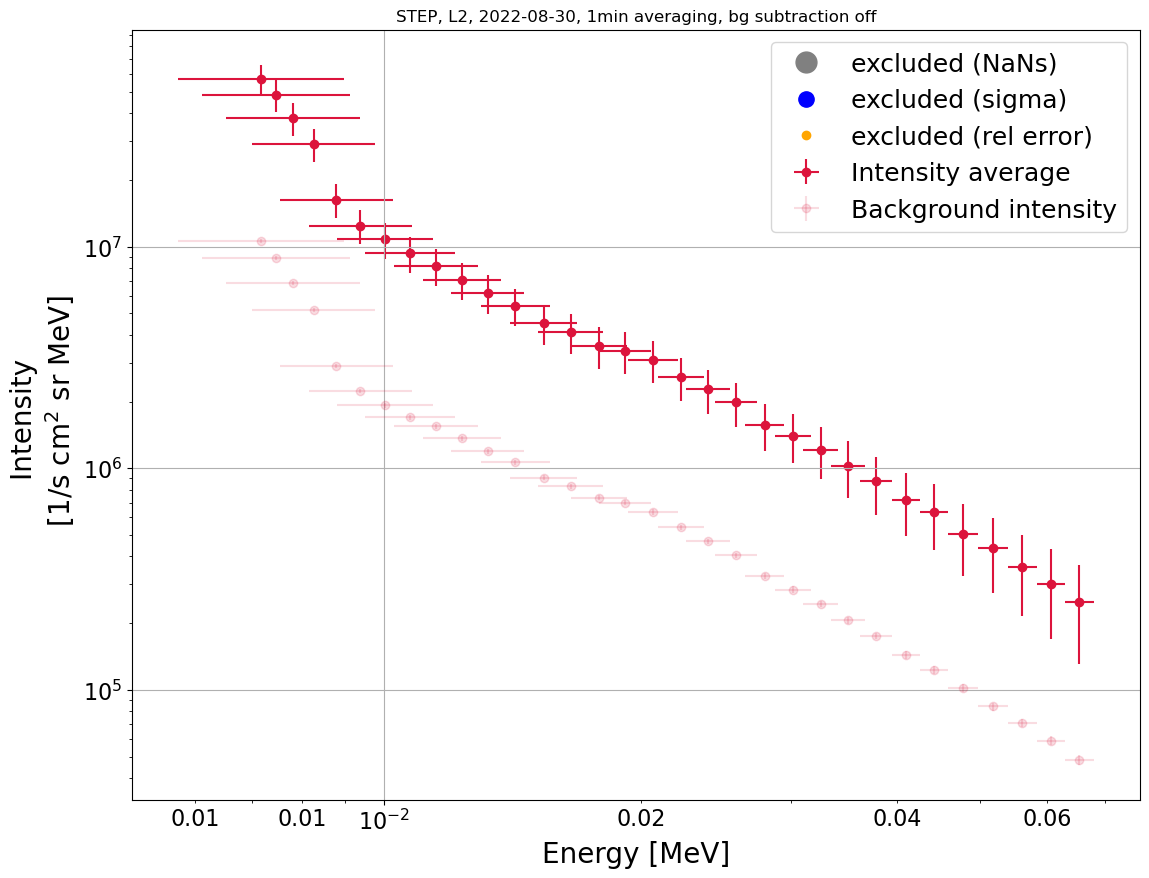

In [14]:
if step:
    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('step', mag_srf)
    else:
        coverage = None
    # calculate resampled STEP electron fluxes (+ ions)
    
    if species.lower() in ['proton', 'protons', 'p']:
        df_particles_step = df_particles_step_org.resample(averaging).mean()
        data_step = extract_proton_data(df_particles_step, energies_step, plot_start, plot_end, t_inj, 
                              bgstart = bg_start , bgend = bg_end, bg_distance_from_window = bg_distance_from_window, 
                              bg_period = bg_period, travel_distance = travel_distance, 
                              travel_distance_second_slope = travel_distance_second_slope, fixed_window = fixed_window, 
                              instrument = 'step', data_type = 'l2', averaging=averaging)
        bg_b = False
        plot_channels_protons(data_step, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'step', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err)
    
    bg_b = False
    plot_spectrum_peak(data_step, species, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold= rel_err, direction = direction)
    plot_spectrum_average(data_step, species, bg_subtraction=bg_b, savefig=saving, path=plot_path, sigma=sigma, frac_nan_threshold=frac_nan_threshold, rel_err_threshold=rel_err, direction=direction)
    
    if saving: write_to_csv(data_step, date_string, direction, species, path=path_to_folder)
    


## EPT

Calculating PA coverage for ept...


100%|██████████| 2880/2880 [00:00<00:00, 10964.75it/s]
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1315: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_proton_uncertainties['Ion_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


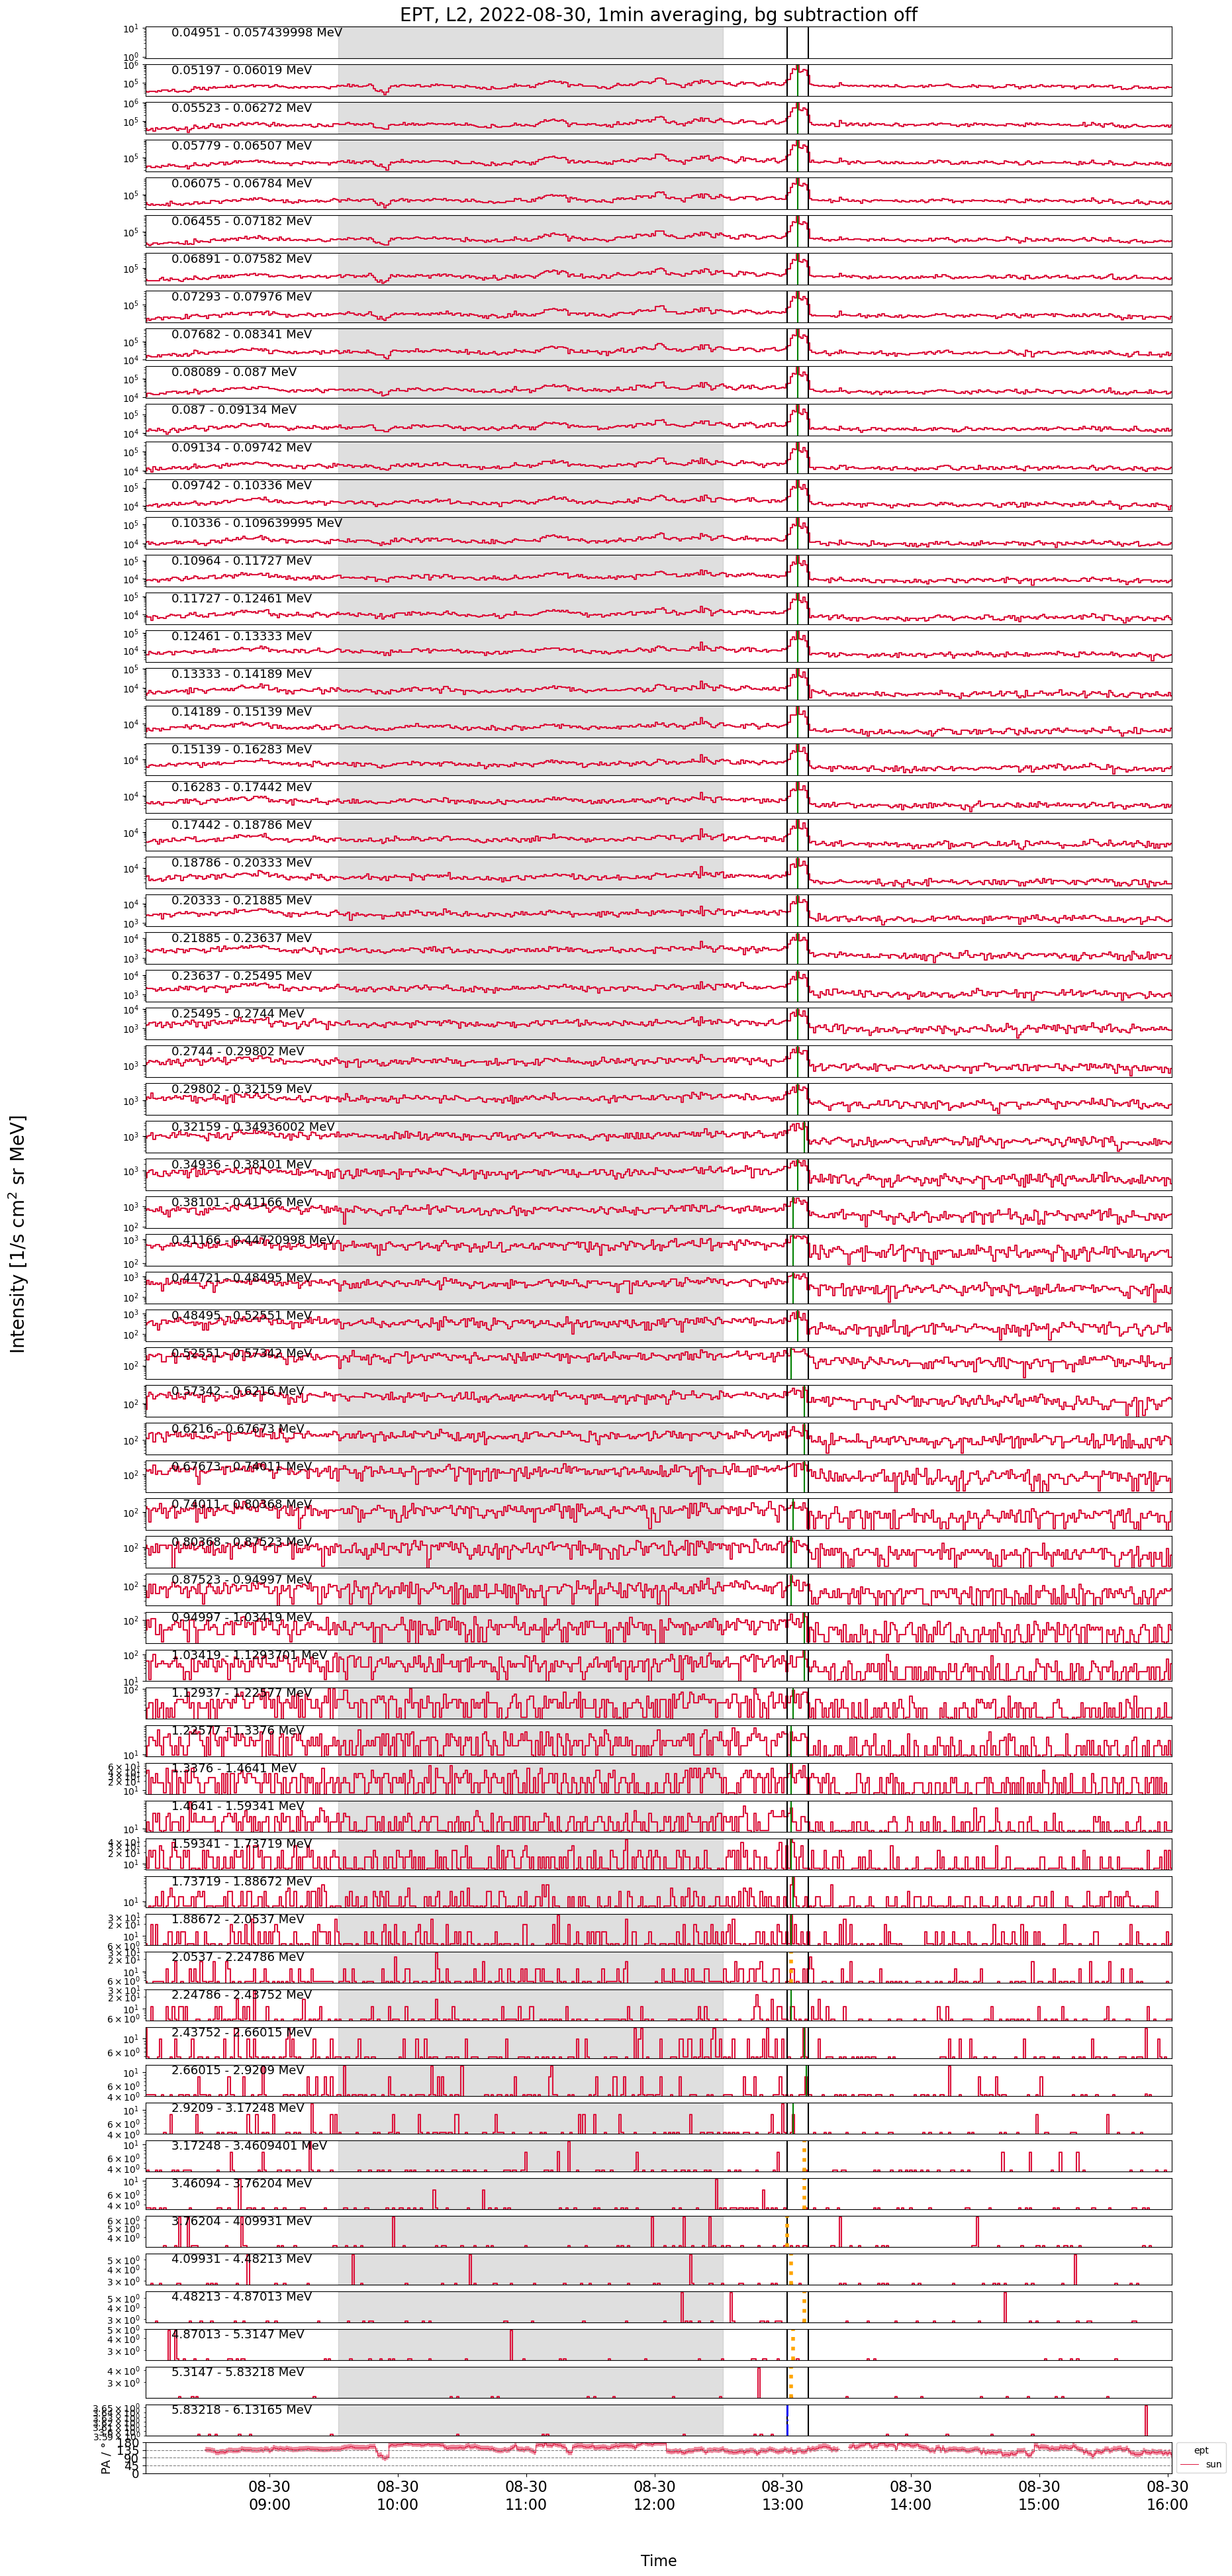

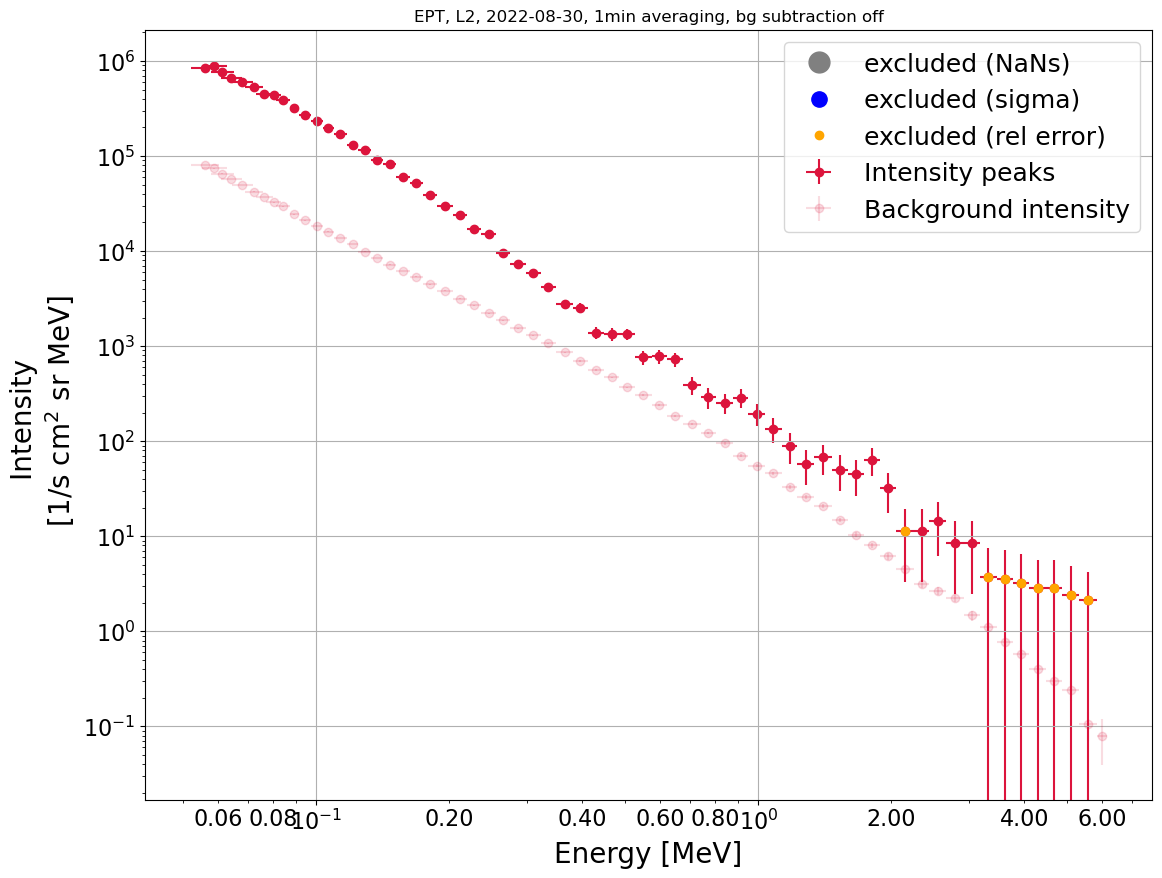

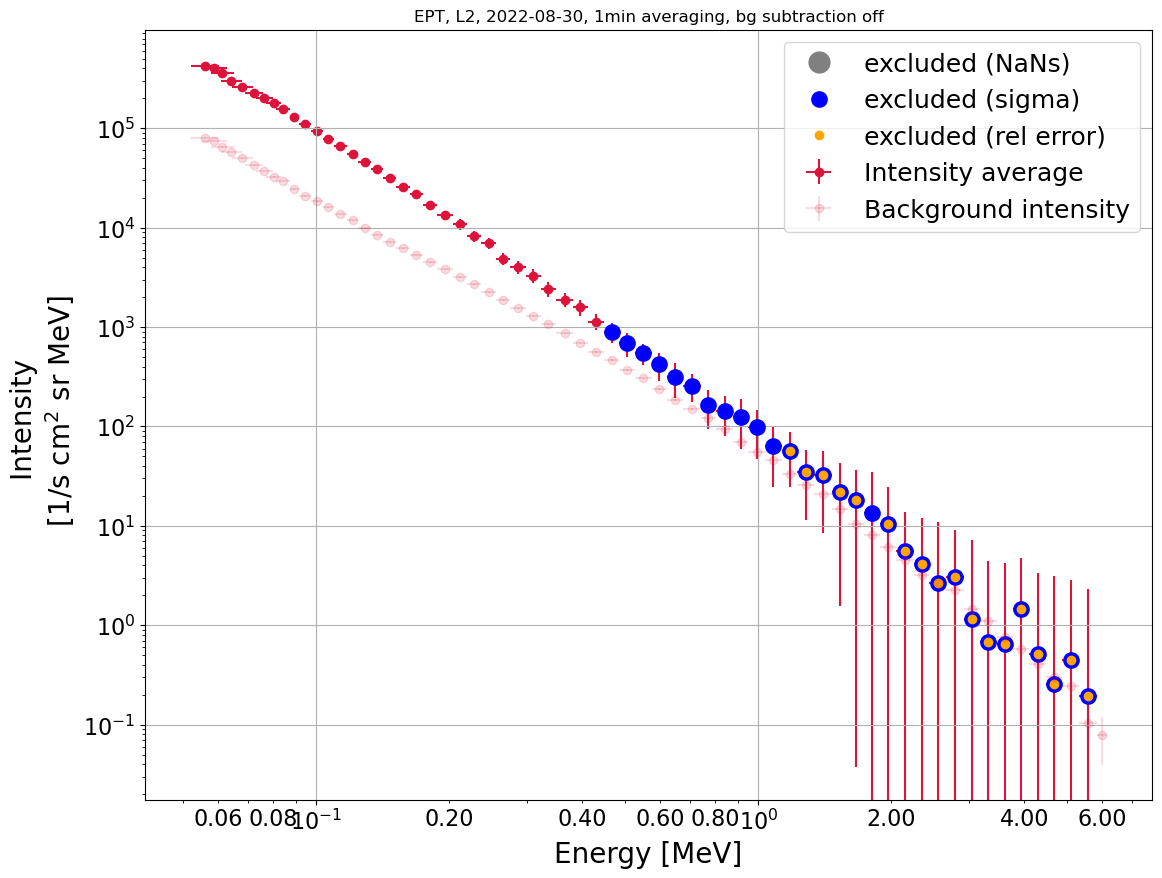

In [15]:
# !!!!!!
if ept:
    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('ept', mag_srf)
    else:
        coverage = None

    
    if species.lower() in ['proton', 'protons', 'p']:
        data_ept = extract_proton_data(df_protons_ept, energies_ept, plot_start, plot_end, t_inj, bgstart = bg_start, 
                                     bgend = bg_end, bg_distance_from_window = bg_distance_from_window, bg_period = bg_period, 
                                     travel_distance = travel_distance, travel_distance_second_slope=travel_distance_second_slope, 
                                     fixed_window=fixed_window, instrument = 'ept', data_type = 'l2', 
                                     averaging=averaging)
        bg_b = False
        plot_channels_protons(data_ept, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'ept', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    
    bg_b = False
    plot_spectrum_peak(data_ept, species, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction) 
    plot_spectrum_average(data_ept, species, bg_subtraction=bg_b, path=plot_path, savefig=saving, direction=direction)

    
    if saving: write_to_csv(data_ept, date_string, direction, species, path=path_to_folder)


In [16]:
quality_factor_PA_coverage(data_ept, coverage, direction = 'sun', angle = 180)

60.0

## HET

Calculating PA coverage for het...


100%|██████████| 2880/2880 [00:00<00:00, 10433.40it/s]
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1315: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_proton_uncertainties['Ion_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1344: RuntimeWarning: invalid value encountered in double_scalars
  list_peak_significance.append(list_bg_subtracted_peaks[i]/list_bg_std[i])
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1350: RuntimeWarning: invalid value encountered in divide
  list_average_significance.append(list_bg_subtracted_average[i]/list_bg_std[i])
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift_electrons_protons.py:1800: UserWarn

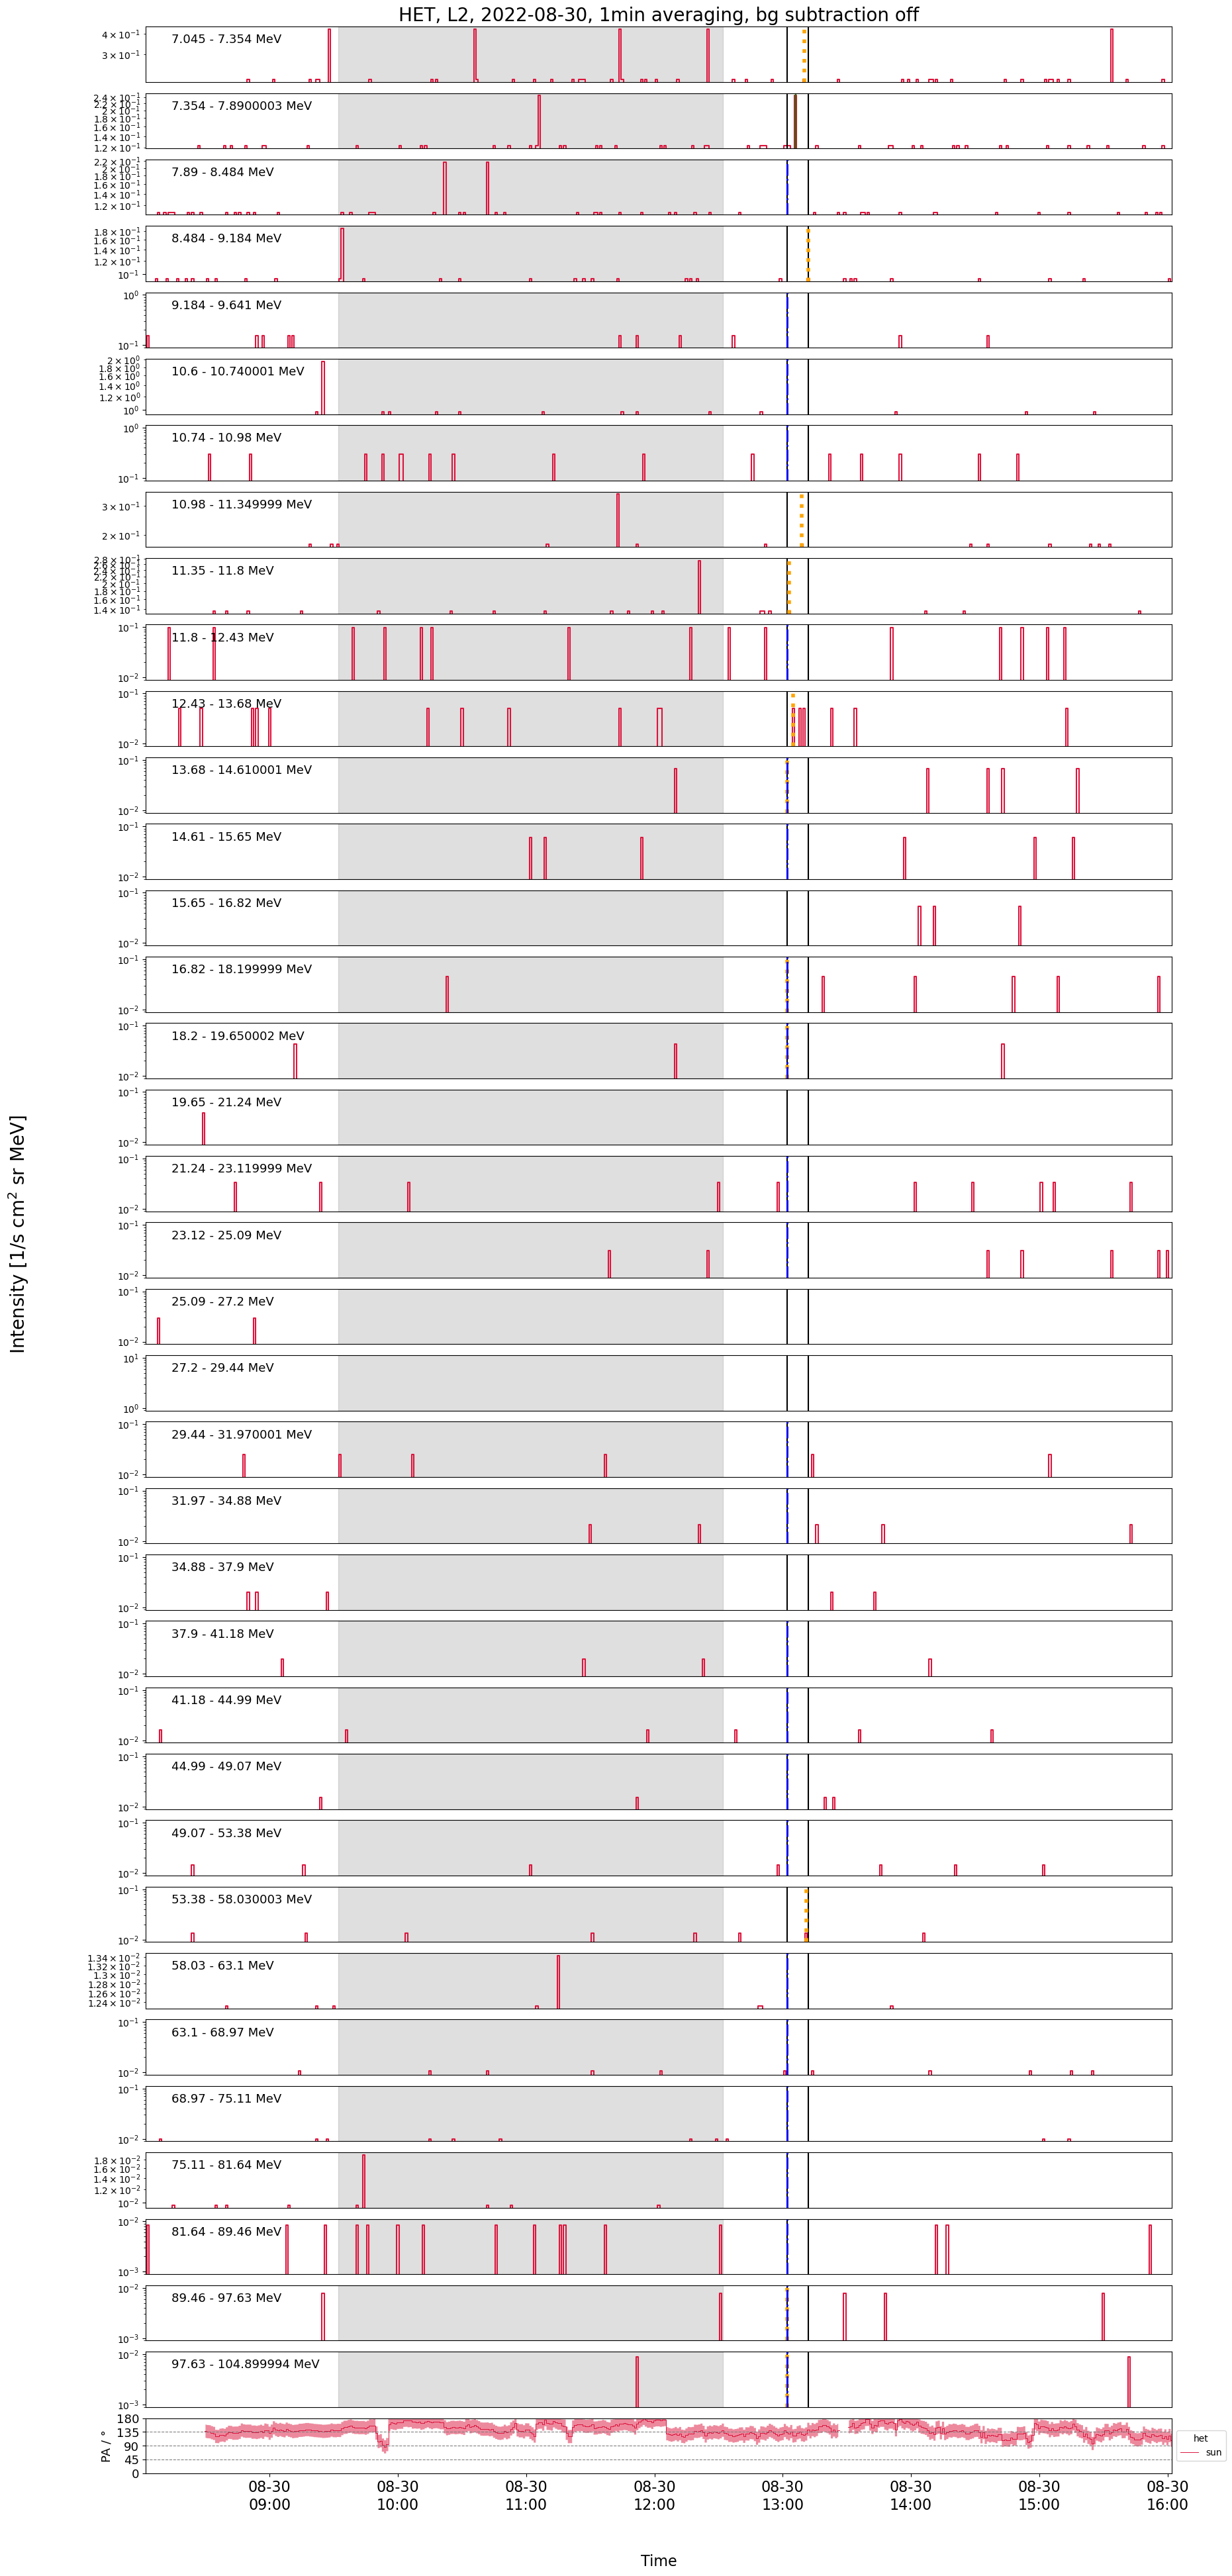

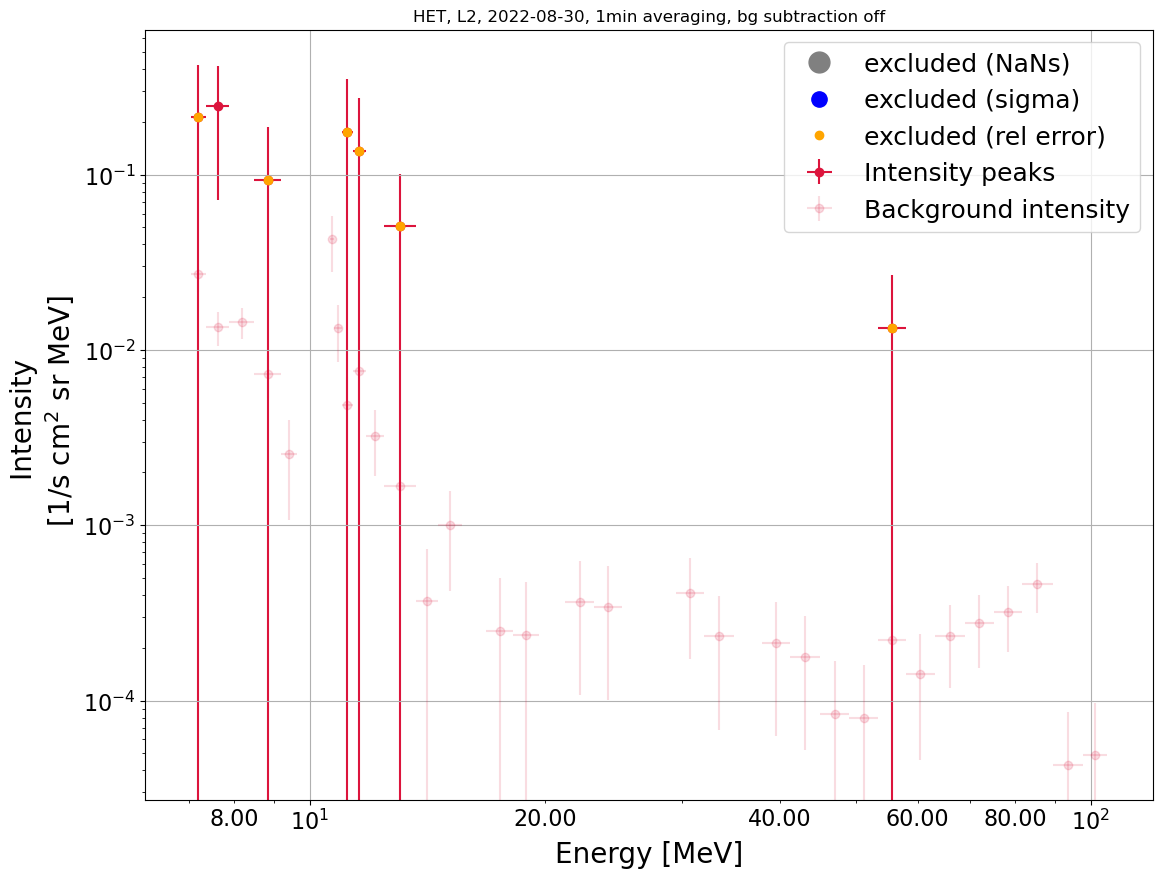

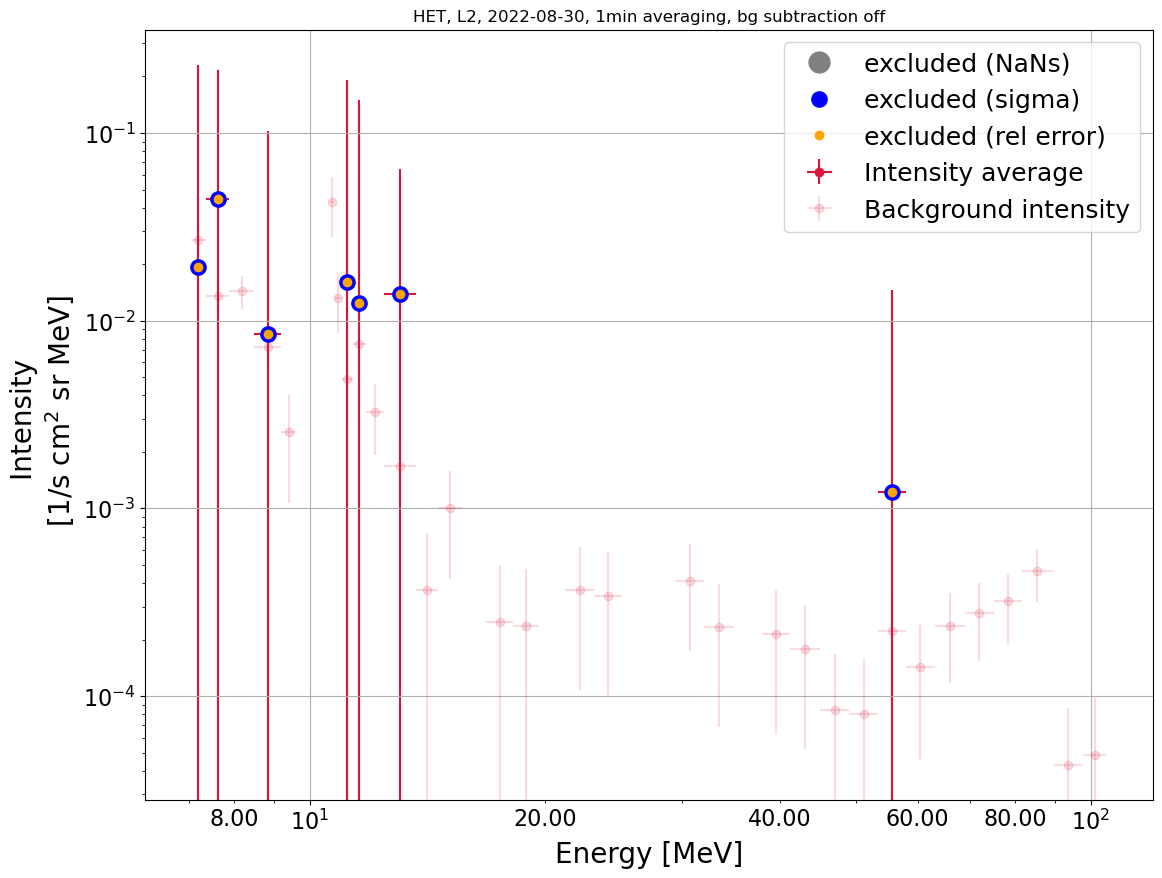

In [17]:
# !!!!!!
if het:
    if plot_pa:
        mag_srf = mag_srf.resample(averaging).mean()
        coverage = calc_pa_coverage('het', mag_srf)
        
    if species.lower() in ['proton', 'protons', 'p']:    
        data_het = extract_proton_data(df_protons_het, energies_het, plot_start, plot_end, t_inj, 
                                     bgstart = bg_start, bgend = bg_end,  bg_distance_from_window = bg_distance_from_window,
                                     bg_period = bg_period, travel_distance = travel_distance, 
                                     travel_distance_second_slope = travel_distance_second_slope, 
                                     fixed_window = fixed_window, instrument='het', data_type='l2', 
                                     averaging=averaging)
        bg_b = False
        plot_channels_protons(data_het, bg_subtraction=bg_b, path=plot_path, savefig=saving, plot_pa=plot_pa, coverage=coverage, sensor = 'het', sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, viewing = direction)
    
    bg_b = False
    plot_spectrum_peak(data_het, species, bg_subtraction=bg_b, path=plot_path, savefig=saving, sigma = sigma, frac_nan_threshold = frac_nan_threshold, rel_err_threshold = rel_err, direction = direction)
    plot_spectrum_average(data_het, species, bg_subtraction=bg_b, path=plot_path, savefig=saving, frac_nan_threshold=frac_nan_threshold, direction=direction)      

    if saving: write_to_csv(data_het, date_string, direction, species, path=path_to_folder)
    

## FIT THE SPECTRUM

#### INPUTS FOR THE FIT
__fit_to__ (string, defaults to 'peak'): 'peak' or 'average'
<br> __fit_type__ (string): the combination of instriment data that will be fit. Options: 'step', 'ept', 'het', 'step_ept', 'ept_het', 'step_ept_het'
<br> __which_fit__ (string): the type of pl function that will be fit to the data. Note that if the data cannot be fit with a specific function the software will choose the next best option. Options: 
<br> __'single'__ will force a single pl fit to the data.
<br> __'broken'__ will force a broken pl fit to the data but ONLY if the break point is within the energy range otherwise a sigle pl fit will be produced instead.
<br> __'best_sb'__ will choose automatically the best fit type between single and broken by comparing the redchis of the fits.
<br> __'cut'__ will produce a single pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken or single pl will be fit instead.
<br> __'broken_cut'__ will produce a broken pl fit with an exponential cutoff point. If the cutoff point is outside of the energy range a broken, cut or single pl will be fit instead.
<br> __'best_cb'__ will choose automatically the best fit type between broken and cut by comparing the redchis of the fits. A single pl will be fit to the data if the other fits are not physical. 
<br> __'triple'__ will try to fit a triple pl to the data. If this is not possible, the next best option will be fit to the data. 
<br> __'best'__ will automatically choose the best out of all the fitting options.

<br> __c1_guess__ (int or float, defaults to 1000): the flux value corresponding to 0.1 MeV
<br> __g1_guess__ (int or float, defaults to -1.9): the slope of a single pl or the first part of a broken or triple pl. __g1_guess__ > __g2_guess__, __g3_guess__ and __g1_guess__< 0.
<br> __g2_guess__ (int or float, defaults to -2.5): the slope of the broken pl after the break or the slope between the two breaks for a triple pl. __g1_guess__> __g2_guess__ >  __g3_guess__ and __g2_guess__< 0.
<br> __g3_guess__ (int or float, defaults to -4): the slope of a triple pl after the second break. __g1_guess__, __g2_guess__ >  __g3_guess__ and __g3_guess__< 0.
<br> __alpha_guess__ and __beta_guess__ (int or float, defaults to 10): the smoothness of the first and second break respectively.
<br> __break_guess_low__ (int or float, defaults to 0.6 MeV): the energy corresponding to the first break in the spectrum (in MeV).
<br>__break_guess_high__ (int or float, defaults to 1.2 MeV): the energy corresponding to the second break in the spectrum (in MeV).
<br> __cut_guess__ (int or float, defaults to 1.2 MeV): the energy corresponding to the exponential cutoff in the spectrum (in MeV).
<br> __e_min__ and __e_max__ (int or float, defaults to None): minimum and maximum energy to fit. If None will automatically be taken as min and max fittable values. step energy range: 0.004323343613-0.07803193193 MeV, ept energy range: 0.03295087252-0.452730295 MeV, het energy range: 0.6859485403-10.62300288 MeV, second het channel: 1.590048112 MeV
<br> __use_random__ (bool, defaults to True): if True the software will choose random values close to the guess values that will be fit to the data to find the fit with the lowest redchisq.
<br> __random_iterations__ (int, defaults to 20): number of times the random values will be chosen.
<br> __leave_out_1st_het_chan__ (bool, defaults to True): If True, the first HET channel will be left out from the fit.
<br> __shift_step_data__ (bool, defaults to False): If True, STEP data will be shifted (up or down, intensity wise) by a factor equal to shift_factor.
<br> __shift_factor__ (float, defaults to None): Factor to shift STEP data (e.g. 0.8). 
<br> __legend_details__ (bool, optional): If True, the final fit type and the reduced chi square will be dislayed in the legend.
	


In [18]:
fit_to = 'average'
fit_type = 'step_ept'
which_fit = 'triple'
detailed_legend = True

c1_guess = 100000
g1_guess = -1.6
g2_guess = -1.8
g3_guess = -2
alpha_guess = 0.5
beta_guess = 10
break_guess_low = 0.2
break_guess_high = 0.2
cut_guess = 2
exponent = 1

e_min = None
e_max = 1

use_random = True
random_iterations = 20

leave_out_1st_het_chan = False
shift_step_data = True
shift_factor = None #0.8
auto_shift = True

detailed_legend = True


In [19]:
bg_subtraction = False

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:78: RuntimeWarning: invalid value encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break_low**alpha)/(0.1**alpha+E_break_low**alpha))**((gamma2-gamma1)/alpha)* ((x**beta + E_break_high**beta)/(0.1**beta+E_break_high**beta))**((gamma3-gamma2)/beta)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:111: RuntimeWarning: overflow encountered in power
  y = c1*(x/0.1)**gamma1 * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)*np.exp(-(x/E_cut)**exponent)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:111: RuntimeWarning: overflow encountered in multiply
  y = c1*(x/0.1)**gamma1 * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)*np.exp(-(x/E_cut)**exponent)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:111: RuntimeWarning: invali

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
STEP INTENSITY AVG 335609.43
EPT INTENSITY AVG 349485.540625
0.960295608796333
SHIFT FACTOR:  0.960295608796333


/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:78: RuntimeWarning: overflow encountered in multiply
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break_low**alpha)/(0.1**alpha+E_break_low**alpha))**((gamma2-gamma1)/alpha)* ((x**beta + E_break_high**beta)/(0.1**beta+E_break_high**beta))**((gamma3-gamma2)/beta)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:140: RuntimeWarning: invalid value encountered in power
  y = c1*(x/0.1)**gamma1 *np.exp(-(x/E_cut)**exponent)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:78: RuntimeWarning: overflow encountered in power
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break_low**alpha)/(0.1**alpha+E_break_

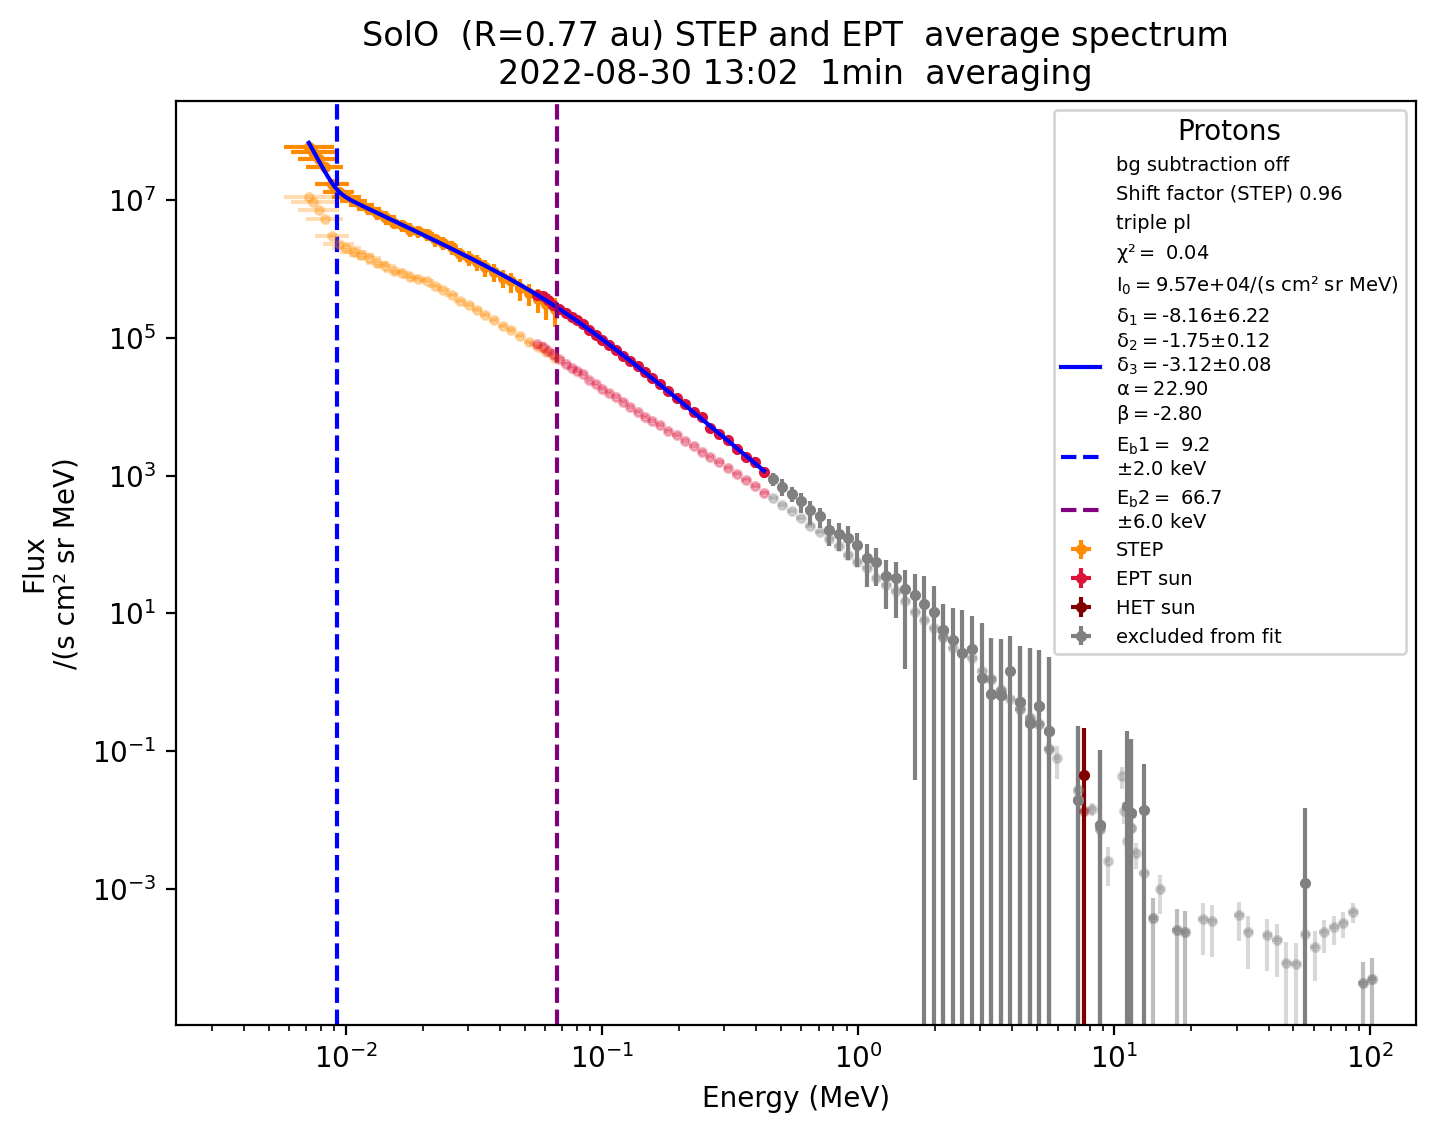

In [20]:
FIT_DATA(path_to_folder, date, averaging = averaging, fit_type= fit_type, step = step, ept = ept, het = het, direction = direction,
         which_fit = which_fit, sigma = sigma, rel_err = rel_err, frac_nan_threshold = frac_nan_threshold, fit_to = fit_to, 
         e_min = e_min, e_max = e_max, g1_guess = g1_guess, g2_guess = g2_guess, g3_guess = g3_guess, c1_guess = c1_guess, 
         alpha_guess = alpha_guess, beta_guess = beta_guess, break_guess_low = break_guess_low, break_guess_high = break_guess_high, cut_guess = cut_guess, exponent_guess = exponent,
         use_random = use_random, iterations = random_iterations, leave_out_1st_het_chan = leave_out_1st_het_chan, shift_step_data = shift_step_data, 
         auto_shift = auto_shift, shift_factor = shift_factor, save_fig = saving, save_pickle = False, save_fit_variables = saving, save_fitrun = saving, legend_details = detailed_legend, 
         bg_subtraction = bg_subtraction, fit_to_separate_folder = plot_n_data_folders,  centre_pix = False)


In [21]:
if save_fit_run_variables_to_separate_folders:
    fit_var_file = date_folder+'-fit-result-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'
    run_var_file = date_folder+'-all-fit-variables_'+fit_type+'-'+fit_to+'-'+which_fit+'-l2-'+averaging+'-'+direction+'.csv'

    save_fit_and_run_variables_to_separate_folders(path, date_folder, fit_var_file, run_var_file)